$\newcommand{\n}[1]{\|#1 \|}$
$\renewcommand{\a}{\alpha}$
$\renewcommand{\b}{\beta}$
$\renewcommand{\c}{\gamma}$
$\renewcommand{\d}{\delta}$
$\newcommand{\la}{\lambda}$
$\newcommand{\e}{\varepsilon}$
$\renewcommand{\t}{\tau}$
$\renewcommand{\th}{\theta}$
$\newcommand{\s}{\sigma}$
$\newcommand{\x}{\bar x}$
$\newcommand{\n}[1]{\left\|#1 \right\|}$ 
$\newcommand{\R}{\mathbb R}            $ 
$\newcommand{\N}{\mathbb N}            $ 
$\newcommand{\Z}{\mathbb Z}            $ 
$\newcommand{\lr}[1]{\left\langle #1\right\rangle}$
$\DeclareMathOperator{\diag}{diag}$
$\DeclareMathOperator{\sign}{sign}$

## **Problem 1: robust regression** 

### (or subgradient method vs. stochastic subgradient method)

*Regression*: we have a sequence of vectors $a_i\in \R^n$ and measurements $b_i\in \R$ for $i=1,\dots, m$. 
We want to predict $b_i$ using $\lr{a_i, x}$ for some unknown $x\in \R^n$. 

Because of possible outliers (or other reasons) $\ell_2$-regression may be not a good choice, we want a more robust approach. 

Given $A\in \R^{m\times n}$ and $b\in \R^m$, minimize
$$ f(x) = \n{Ax-b}_1  = \sum_{i=1}^m |\lr{a_i,x} - b_i|$$


What should we consider?

 - Is the problem convex?
 - Is the problem smooth / constrained?
 - What are the dimensions?
 - What is the most efficient method to solve it?
 
 
 We will only compare subgradient method with stochastic subgradient method.
 
***Warning***: there exist more efficient methods for this problem.
 
#### **Computing the subgradient**
 What is the subgradient of $f$ at $x$? For $y\mapsto \n{y}_1$ it is $\sign(y)$ (at zero any value from $[-1,1]$ will work). Thus,
 $$g(x) = \tilde \nabla f(x) = A^\top \sign(Ax-b) = \sum_{i=1}^m a_i \sign(\lr{a_i,x} -b_i)$$
 
#### **Computing the stochastic subgradient**
 What is the stochastic subgradient of $f$ at $x$? One option is to take
 $$g(x, i) = m \tilde \nabla f_i(x) = m a_i \sign(\lr{a_i, x} -b_i)$$
 
 <font color='red'> **Question**: </font>  Why do we multiply by $m$ here?

In [18]:
using LinearAlgebra
using Plots
using Random 
using StatsBase: sample

We will use synthetic data, generated as follows
- $A$ is Gaussian $m\times n$ matrix, each entry is iid $N(0,1)$.
- $w\in \R^n$ is Gaussian vector, each entry is iid $N(0,1)$, it is a "true" predictor for clean data
- $b_i = \lr{a_i, w} + \e_i|\e_i|^3$, where $\e_i\sim N(0,1)$ 
- set $m=100$ and $n=50$

In [20]:
m, n = 100, 50
Random.seed!(42);
A = randn(m, n)
w = randn(n)
ε = randn(m)
b = A * w .+ ε .* abs.(ε.^3)

f(x) = norm(A * x - b, 1)
g(x) = A' * sign.(A * x - b)
stoch_g(x, i) = m * A[i, :] * sign(dot(A[i,:], x) - b[i]);

stoch_g (generic function with 1 method)

In [21]:
function subgrad_method(f, g, x0, steps; iter=1000)
    x=x0
    values = [f(x)]
    for k in 1:iter
        x -= steps[k]*g(x)
        append!(values, f(x))
    end
    return values, x

end

function stoch_subgrad_method(f, stoch_g, x0, steps, m; iter=1000)
    x=x0
    values = [f(x)]
    for k in 1:iter
        psi = sample(1:m)
        x -= steps[k]*stoch_g(x, psi)
        append!(values, f(x))
    end
    return values, x
end

;

In [23]:
using Flux

┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1317
  ** incremental compilation may be fatally broken for this module **

┌ Warning: Module Colors with build ID 332185228180101 is missing from the cache.
│ This may mean Colors [5ae59095-9a9b-59fe-a467-6f913c188581] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1008
┌ Info: Skipping precompilation since __precompile__(false). Importing Flux [587475ba-b771-5e3f-ad9e-33799f191a9c].
└ @ Base loading.jl:1025
┌ Warning: The NVIDIA driver on this system only supports up to CUDA 10.2.0.
│ For performance reasons, it is recommended to upgrade to a driver that supports CUDA 11.2 or higher.
└ @ CUDA C:\Users\user\.julia\packages\CUDA\mVgLI\src\initialization.jl:42


LoadError: LoadError: InitError: InterruptException:
during initialization of module Flux
in expression starting at C:\Users\user\.julia\packages\Flux\0c9kI\src\Flux.jl:1

In [24]:
u = randn(n)
subgrad(x) = gradient(f, x)[1]
g(u) - subgrad(u)

LoadError: UndefVarError: gradient not defined

In [25]:
x0 = ones(n)
N = 1000
α = 0.1
steps1 = α ./ sqrt.(collect(1:N))
steps2 = 0.1*α ./ sqrt.(collect(1:N*m))
obj_subgrad, x1 = subgrad_method(f, g, x0, steps1; iter=N);
obj_stoch, x2 = stoch_subgrad_method(f, stoch_g, x0, steps2, m; iter=N*m);


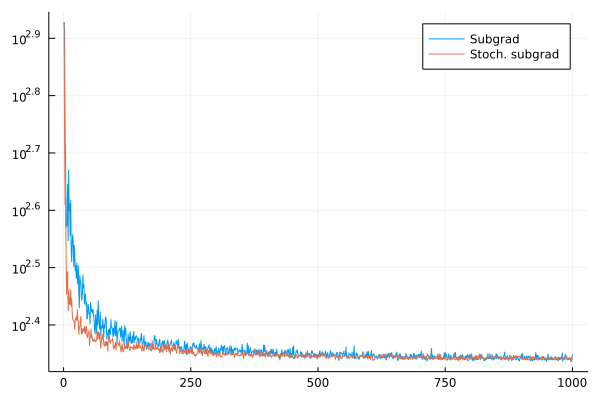

In [26]:
plot(obj_subgrad, yscale=:log10, label="Subgrad")
plot!(obj_stoch[1:m:end], label="Stoch. subgrad")

Now, let us experiment with different stepsizes. We compare both algorithms for all $\a\in [0.001, 0.01, 0.05, 0.1]$

In [31]:
dict_subgrad = Dict()
dict_stoch = Dict()

N = 1000
α_array = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

for (i, α) in enumerate(α_array)
    dict_subgrad[i], _ = subgrad_method(f, g, x0, α * steps1; iter=N);
    dict_stoch[i], _ = stoch_subgrad_method(f, stoch_g, x0, α * steps2, m; iter=N*m);

end    

min_obj1 = minimum([minimum(d) for  d in values(dict_subgrad)])
min_obj2 = minimum([minimum(d) for  d in values(dict_stoch)])
min_obj = min(min_obj1, min_obj2) - 0.1;

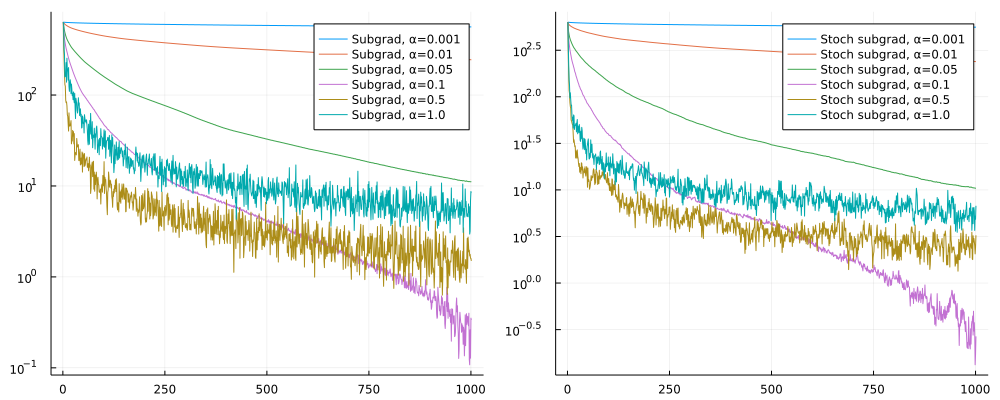

In [32]:
p1 = plot()
p2 = plot()

for i in 1:length(α_array)
    p1 = plot!(p1, dict_subgrad[i] .- min_obj, yscale=:log10, label="Subgrad, α=$(α_array[i])")
    p2 = plot!(p2, dict_stoch[i][1:m:end] .- min_obj, yscale=:log10, label="Stoch subgrad, α=$(α_array[i])")
end
plot(p1, p2, layout=2, size = (1000, 400))


What about other choices for steps? For example, $\a_k = \frac{\a}{\beta + \sqrt k}$?

## Stochastic subgradient method with random reshuffling

In practice the following version of SGD is often used:

`for` $k=1,2,\dots$ `do`

$\quad$ $x_k^1 = x_k$


$\quad$ make a random permutation $\sigma$ of $\{1,\dots,m\}$

$\quad$ `for` $i$ `in` $1,\dots, m $ `do`

$\qquad$ $x_k^{i+1} = x_k^i - \a_k \tilde\nabla f_{\sigma(i)}(x_k^i)$

$\quad$ `endfor`

$\quad$ $x_{k+1} = x_k^{m+1}$

`endfor`

It is called SGD with *random reshuffling* (also SGD without replacement)

 <font color='red'> **Question**: </font>  What are the possible issues with this method?
 
 **Task**: implement SGD-RR and compare it with SGD for the previous problem

In [50]:
zeros(Int8, (2, 3))

2×3 Matrix{Int8}:
 0  0  0
 0  0  0

In [ ]:
function stoch_subgrad_method_rr(f, stoch_g, x0, steps, m; epoch=1000)
    x = x0
    #write the code
    return values, x
end

In [ ]:
dict_stoch_rr = Dict()

N = 1000
α_array = [0.001, 0.01, 0.05, 0.1]

for (i, α) in enumerate(α_array)
    dict_stoch_rr[i], _ = stoch_subgrad_method_rr(f, stoch_g, x0, α * steps1, m; epoch=N);

end    

min_obj = min(min_obj, minimum([minimum(d) for  d in values(dict_stoch_rr)]));

In [ ]:
p3 = plot()

for i in 1:length(α_array)
    p3 = plot!(p3, dict_stoch_rr[i] .- min_obj, yscale=:log10, label="Stoch subgrad-RR, α=$(α_array[i])")
end
plot(p2, p3, layout=2, size = (1000, 400))


## **Problem 2: Constrained robust regression** 

### (or projected subgradient method vs. projected stochastic subgradient method)

Given $A\in \R^{m\times n}$ and $b\in \R^m$, minimize
$$ f(x) = \n{Ax-b}_1  = \sum_{i=1}^m |\lr{a_i,x} - b_i| \quad \text{subject to} \quad \n{x} \leq r $$

We will use the same data as before and $r = \n{w}$.

In [ ]:
m, n = 100, 50
A = randn(m, n)
w = randn(n)
ε = randn(m)
b = A * w .+ ε .* abs.(ε.^3)
r = norm(w)


f(x) = norm(A * x - b, 1)
g(x) = A' * sign.(A * x - b)
stoch_g(x, i) = m * A[i, :] * sign(A[i, :]' * x - b[i]);
proj_ball(x) = norm(x) <= r ? x : x / norm(x) * r;

# or a bit longer but more readable
#function proj_ball(x)
#    norm_of_x = norm(x)
#    if norm_of_x > r
#        x = x / norm_of_x * r
#    return x
#end


In [ ]:
function proj_subgrad_method(f, g, x0, steps; iter=1000)
    return end
end

function proj_stoch_subgrad_method(f, stoch_g, x0, steps, m; iter=1000)
    return end
end


In [ ]:
dict_proj_subgrad = Dict()
dict_proj_stoch = Dict()

N = 1000
α_array = [0.001, 0.01, 0.05, 0.1]

for (i, α) in enumerate(α_array)
    dict_proj_subgrad[i], _ = proj_subgrad_method(f, g, x0, α * steps1; iter=N);
    dict_proj_stoch[i], _ = proj_stoch_subgrad_method(f, stoch_g, x0, α * steps2, m; iter=N*m);

end    

min_obj1 = minimum([minimum(d) for  d in values(dict_proj_subgrad)])
min_obj2 = minimum([minimum(d) for  d in values(dict_proj_stoch)])
min_obj = min(min_obj1, min_obj2)-0.1;

In [ ]:
p4 = plot()
p5 = plot()

for i in 1:length(α_array)
    p4 = plot!(p4, dict_proj_subgrad[i] .- min_obj, yscale=:log10, label="Subgrad, α=$(α_array[i])")
    p5 = plot!(p5, dict_proj_stoch[i][1:m:end] .- min_obj, yscale=:log10, label="Stoch subgrad, α=$(α_array[i])")
end
plot(p4, p5, layout=2, size = (1000, 400))


## **Real data**

We are going to classify images from the standard dataset MNIST.

In [33]:
using MLDatasets

In [34]:
train_a, train_b = MNIST.traindata()

(N0f8[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

N0f8[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

N0f8[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

...

N0f8[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

N0f8[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8]

N0f8[0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; … ; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8; 0.0N0f8 0.0N0f8 … 0.0N0f8 0.0N0f8], [5, 0, 4, 1, 9, 2, 1, 3, 1, 4  …  9, 2, 9, 5, 1, 8, 3, 5, 6, 8])

In [35]:
using ImageCore
MNIST.convert2image(train_a[:,:,10])

Suppose for simplicty we have only images with "0" or "1".  We want to classify them.

Hence, we have points $a_1,\dots, a_n\in \R^{28\times 28}$ with labels $b_i = +1$ or $-1$ (for 0 and 1 respectively)


We will use hinge loss for this
$f_i(x) = \max(0, 1 - b_i \cdot \lr{a_i,x})$

Roughly speaking, this function is small when $\sign(a_i,x)$ coincides with the sign of $b_i$.

Hence, 
$$f(x) = \frac 1 n \sum_{i=1}^n f_i(x)$$




In [44]:
all_points = MNIST.traintensor(Float32, 1:1000)
all_labels = MNIST.trainlabels(1:1000)
points = Iterators.flatten(all_points[:,:, all_labels.< 2])
labels = 2*all_labels[all_labels.< 2] .- 1

213-element Vector{Int64}:
 -1
  1
  1
  1
  1
 -1
  1
  1
 -1
 -1
  1
 -1
 -1
  ⋮
  1
 -1
 -1
  1
  1
 -1
  1
 -1
  1
 -1
  1
 -1

In [45]:
hinge_loss(x, a, b) = max(0.0, 1.0 - b * dot(a, x))

function subgrad_hinge_loss(x, a, b)
    s = b * dot(a,x)
    if s >= 1
        g = zeros(size(x))
    else
        g = - b * a
    end
    return g
end

function f(x)
    res = 0.0
    n = length(labels)
    for i in 1:n
       res += hinge_loss(x, points[:,i], labels[i]) 
    end
    return 1/n * res
end


function g(x)
    n = length(labels)
    subgrad = zeros(size(x))
    for i in 1:n
       subgrad += subgrad_hinge_loss(x, points[:, i], labels[i]) 
    end
    return 1/n * subgrad
end

stoch_g(x, i) = subgrad_hinge_loss(x, points[:, i], labels[i]);


In [46]:
d = size(points)[1]
n = size(points)[2]

x0 = zeros(d)
N = 10
α = 0.1
steps1 = α ./ sqrt.(collect(1:N))
steps2 = α ./ sqrt.(collect(1:N*n))
obj_subgrad, x1 = subgrad_method(f, g, x0, steps1; iter=N);
obj_stoch, x2 = stoch_subgrad_method(f, stoch_g, x0, steps2, n; iter=N*n);


LoadError: MethodError: no method matching size(::Base.Iterators.Flatten{Array{Float32, 3}})
[0mClosest candidates are:
[0m  size([91m::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\LinearAlgebra\src\qr.jl:524
[0m  size([91m::Union{QR, LinearAlgebra.QRCompactWY, QRPivoted}[39m, [91m::Integer[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\LinearAlgebra\src\qr.jl:523
[0m  size([91m::Union{Cholesky, CholeskyPivoted}[39m) at C:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.6\LinearAlgebra\src\cholesky.jl:442
[0m  ...

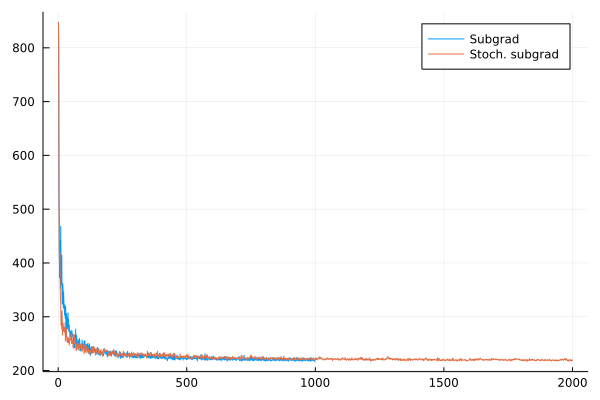

In [40]:
plot(obj_subgrad, labels="Subgrad")
plot!(obj_stoch[1:n:end], labels="Stoch. subgrad")

After finding a good $x$, we can use test data in MNIST dataset to check how good we are in classifying $0$ from $1$.

In [ ]:
all_test_points = MNIST.testtensor(Float32)
all_test_labels = MNIST.testlabels()
test_points = Iterators.flatten(all_test_points[:,:, all_labels.< 2])
test_labels = 2*all_labels[all_test_labels.< 2] - 1

In [ ]:
success = 0
for i in 1:length(test_labels)
    if sign(dot(test_points[:, i], x_sol)) = test_labels[i]
        success += 1
    end
end

print(success/length(test_labels))